# MESS - Morhpological Equal-area Standardized Segmentation

**Main function: segment(** *mask, video=None, fr=None, n_ROIs_out=16, n_ROIs_in=16* **)**

Return ROIs masks, means from ROIs masks and time.

Divide cell mask into two major regions (inner and outter region), then divide these regions into smaller regions of interest (ROIs) with similar area following cell shape. The number of ROIs in each major region can be adjusted by *n_ROIs_out* and *n_ROIs_in* arguments. Also, get ROIs means over time from video.

**Parameters:**  
- **mask: boolean array**
    - (M x N) boolean array. Must match video dimensions. It can be loaded or drawn below.
- **video: array, optional**
    - (F x M x N) 16-bit gray image stack, where F are frames, M are lines and N are columns.
- **fr: float, optional**
    - video frame rate (in frames per second). Necessary if video is provided.
- **n_ROIs_out: int, optional**
    - number of ROIs in the outter region.
- **n_ROIs_in: int, optional**
    - number of ROIs in the inner region.
 
**Returns:**
- **stack_ROIs: boolean array**
    - (R x M x N) image stack, where R are ROI numbers (R = n_ROIs_in + n_ROIs_out), M are lines and N are columns.
- **label_ROIs: boolean array**
    - (M x N) image, where each ROI is labeled by different numbers in the image (0 for background), M are lines and N are columns.
- **ROIs_means: array (only if video and fr are provided)**
    - (F x R) array, where F are frames and R are ROI numbers.
- **time: array (only if video and fr are provided)**
    - (F,) array, where F are time points.


In [34]:
testing = (__name__ == "__main__")
if testing:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os
    mespath = os.path.abspath('')
    if mespath not in sys.path:
        sys.path.append(mespath)

## Mandatory Parameters (load video and frame rate):

In [35]:
if testing:
    from skimage import io
    global fpath
    fpath = 'Data\\Cell2\\Videos_AP'
    fr = 71.29 #55.78
    fname = 'vid1.tif'
    fullpath = fpath + '\\' + fname
    video = io.imread(fullpath)

### Still don't have a cell mask? Draw it manually or generate it automatically (plus manual editing if necessary):

In [36]:
if testing:
    mask_method = 'draw' # or 'load' if you already have mask file stored

In [37]:
def build_contour(msk):
    '''Generates a gray contour from binary masks and extracts the contour'''
    import scipy.ndimage as sm
    import numpy as np
    msk_d = sm.binary_dilation(msk,structure=np.ones((3,3)),iterations=1)
    msk_contour_gray = msk_d.astype(int) + msk.astype(int)
    from skimage import measure
    contour = measure.find_contours(msk_contour_gray, 1, positive_orientation = 'high')
    if len(contour)>1:
        largest = np.size(contour[0])
        for c in contour:
            if np.size(c)>np.size(largest):
                largest = c
        contour=largest
    else:
        contour = contour[0]
    return(contour)

<IPython.core.display.Javascript object>


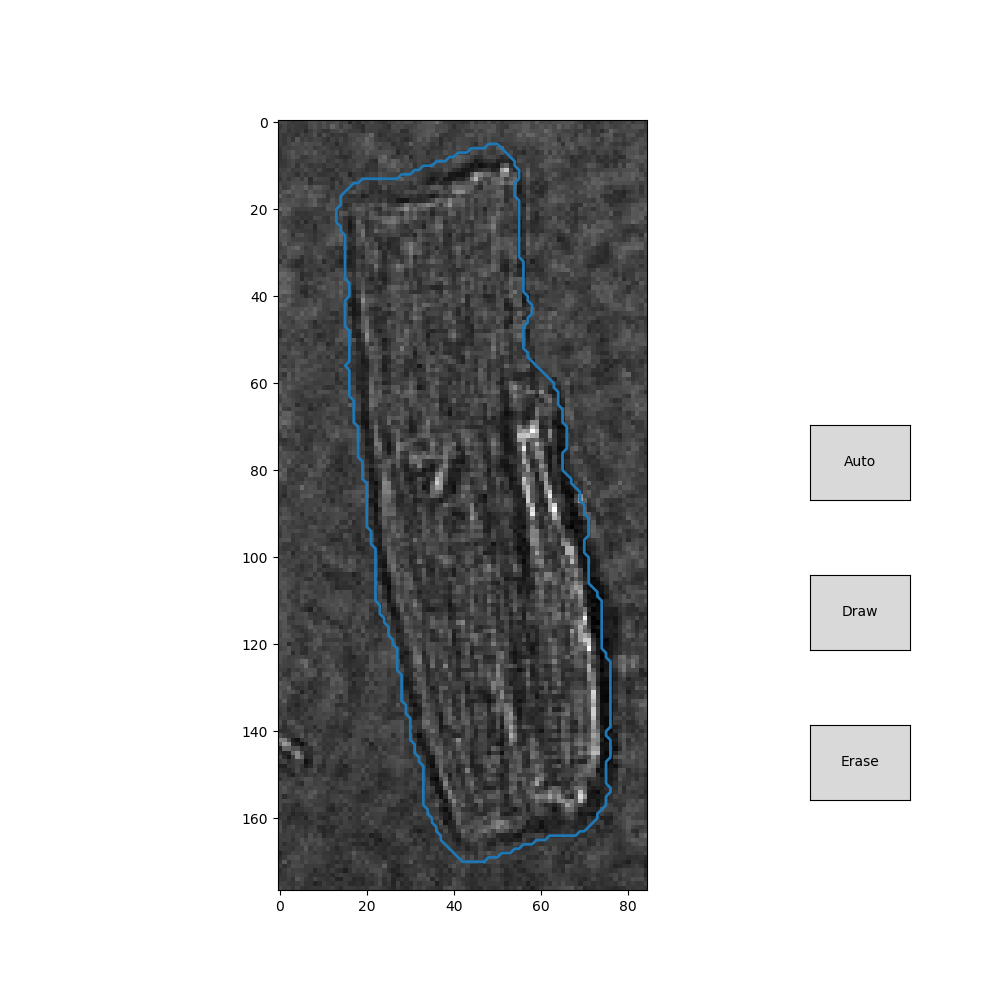

Button(description='Done', layout=Layout(border='solid 5px', height='80px', margin='0px 0px 0px 350px', width=…

Output()

C:\Users\Marcelo\Anaconda3\envs\wxpython and pyinstaller\lib\site-packages\ipykernel_launcher.py:166: UserWarning: No mask drawn, please run this cell again, draw a mask or click on the 'Auto' button before clicking on 'Done'


In [40]:
if testing:
#     global mask, fig_draw, ax_draw, video_list, im, b_satlist, pix, done, erase
    b_satlist = []
    done = False
    video_list = [video]
    if mask_method=='draw':
        
        #change backend so user can interact with it
        %matplotlib notebook
        %matplotlib notebook
        import matplotlib.pyplot as plt
        
        from matplotlib.widgets import LassoSelector
        from matplotlib.widgets import Button
        from ipywidgets import Button as wButton
        from ipywidgets import Output, Layout
        from skimage import io
        # Show snap image
        fig_draw, ax_draw = plt.subplots(figsize=[10,10])
        im_address = fpath + '//snap.tif'
        im = io.imread(im_address)
        #If snap is in RGB format, change it to grayscale (8-bits)
        if len(im.shape)>2:
            from skimage.color import rgb2gray
            im = rgb2gray(im)*255
        ax_draw.imshow(im, cmap='gray')
        plt.subplots_adjust(right=0.8)
        x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
        pix = np.vstack((x.flatten(), y.flatten())).T
        #creates empty mask
        mask = np.zeros_like(im).astype(bool)
        #global variable that define if drawing or erasing shape
#         fig_draw.canvas.draw_idle()
        erase = False
        def onselect(verts):
            from matplotlib.path import Path
            from skimage.measure import label, regionprops
            from skimage.morphology import remove_small_holes
            
            global erase, mask, b_satlist, video_list, fig_draw, ax_draw, im, pix
            b_satlist = []
            ax_draw.axes.clear()
            ax_draw.imshow(im, cmap='gray')
            # Select elements in original array bounded by selector path:
            p = Path(verts)
            ind = p.contains_points(pix, radius=1)
            selected = np.zeros_like(im)
            selected.flat[ind] = im.flat[ind]
            if erase==False:
                mask[selected>0] = True
            else:
                mask[selected>0] = False
                
            #If the user draws more than one element, retain only the biggest
            label_image = label(mask, background=0)
            global props
            props = regionprops(label_image, coordinates='xy')
            def myFunc(e):
                return(e.area)
            props.sort(key=myFunc,reverse=True)
            while len(props)>1:
                props.pop()
            #Redraw the mask with only the biggest element
            mask[:,:] = False
            mask[props[0].coords[:,0],props[0].coords[:,1]] = True
            #removes internal holes
            remove_small_holes(mask,props[0].area,in_place=True)
            #Generates the contour to display over image
            contour = build_contour(mask)
            for i in range(len(video_list)):
                b_satlist.append(mask.astype(bool))
            ax_draw.plot(contour[:,1],contour[:,0],lw=2)
            fig_draw.canvas.draw_idle()

        #lasso tool to manually draw/erase shape
        lineprops = {'color': 'red', 'linewidth': 2, 'alpha': 0.8}
        lasso = LassoSelector(ax_draw, onselect,lineprops=lineprops,useblit=False)

        class ManualDraw(object):
            ind = 0
            def draw_activation(self, event):
                global erase
                erase=False
            def erase_activation(self, event):
                global erase
                erase=True
            
            def on_auto(self,event):
                
                global video_list, mask, fig_draw, ax_draw, b_satlist, im
                ax_draw.axes.clear()
                ax_draw.imshow(im, cmap='gray')
                #clear mask
                mask[:,:] = False
                from skimage.filters import threshold_otsu, threshold_local
                from skimage.morphology import remove_small_objects
                from skimage.segmentation import clear_border
                import scipy.ndimage as sm
                b_satlist = []
                for v,i in zip(video_list,range(len(video_list))):
                    #get video/image type
                    ptype = str(v.dtype)
                    if ptype.startswith('uint'):
                        pixel_depth = int(ptype[4:])
                    #estimate number of pixel additions until saturation
                    f0mean = np.mean(v[0])
                    temp = (2**pixel_depth)//f0mean
                    n_sum_til_saturation=temp.astype(int)

                    f_sat = np.zeros_like(v[0],dtype='uint32')
                    b_sat = np.zeros_like(v[0],dtype='bool')

                    #add first images pixel by pixel until some pixels saturate
                    for j in range(n_sum_til_saturation-1):
                        f_sat = np.add(f_sat,v[j])
                    #Identify which pixels are overflown
                    sat_values = f_sat>(2**pixel_depth)-1
                    #Set overflown pixels to max value based on pixel depth
                    f_sat[sat_values] = (2**pixel_depth)-1
                    #Small blur
                    f_sat = sm.gaussian_filter(f_sat,sigma=2)

                    f_sat = f_sat.astype(v.dtype)
                    #Get image dimensions
                    min_dim = np.amin(b_sat.shape)
                    max_dim = np.amax(b_sat.shape)
                    #Define block_size for local Thresholding
                    block_size = (min_dim//2)
                    #It must be odd (requirement of 'threshold_local')
                    if block_size%2==0:
                        block_size+=1
                    #Make saturated image binary with local threshold
                    thresh = threshold_local(f_sat, block_size, method='gaussian', offset=0, mode='reflect')#, cval=np.amin(f_sat))
                    b_sat = f_sat > thresh
                    #Morphological operations to close holes, connect parts, remove smaller objects
                    #Overall effect of smoothing shape
                    b_sat = sm.binary_opening(b_sat,iterations=2)
                    b_sat = sm.binary_closing(b_sat,iterations=3)
                    b_sat = sm.binary_fill_holes(b_sat)
                    b_sat = remove_small_objects(b_sat,(max_dim*min_dim)//10)
#                     print((max_dim*min_dim)//10)
                    # Remove artifacts connected to image border
                    b_sat = clear_border(b_sat)
                    mask=b_sat.astype(bool)
                    #Generates the contour to display over image
                    contour = build_contour(mask)
                    b_satlist.append(mask.astype(bool))
                    ax_draw.plot(contour[:,1],contour[:,0],lw=2,label='mask_vid_'+str(i+1))
                ax_draw.legend(loc=(1.04,1))
                fig_draw.canvas.draw_idle()
        
        def on_bok_clicked(b):
            import warnings
            from skimage import img_as_ubyte
            from skimage import io
            global video_list, b_satlist, fpath, done
            if len(b_satlist)>0:
                done = True
                #disables user interaction with image
                get_ipython().magic('matplotlib inline')
                for i in range(len(video_list)):
                    #Save masks in same folder as videos
                    impath = fpath + '//manualcellmask' + str(i+1) + '.tif'
                    io.imsave(impath, img_as_ubyte(b_satlist[i]))
            else:
                warnings.warn("No mask drawn, please run this cell again, draw a mask or click on the \'Auto\' button before clicking on \'Done\'", UserWarning)
        
        #Set buttons Draw, Erase, Auto and Done
        callback = ManualDraw()
        axauto = plt.axes([0.81, 0.5, 0.1, 0.075])
        axdraw = plt.axes([0.81, 0.35, 0.1, 0.075])
        axerase = plt.axes([0.81, 0.20, 0.1, 0.075])
#         axok = plt.axes([0.81, 0.05, 0.1, 0.075])
        bdraw = Button(ax=axdraw, label='Draw')
        bdraw.on_clicked(callback.draw_activation)
        berase = Button(ax=axerase,label='Erase')
        berase.on_clicked(callback.erase_activation)
        bok = wButton(description="Done",style = {'font_weight': 'bold', 'button_color': 'green'},
                      layout=Layout(width='25%', height='80px',margin='0px 0px 0px 350px', border='solid 5px'))
        output = Output()
        display(bok, output)
        bok.on_click(on_bok_clicked)
#         bok = Button(ax=axok, label='Done')
#         bok.on_clicked(callback.on_OK)
        bauto = Button(ax=axauto, label='Auto')
        bauto.on_clicked(callback.on_auto)
        fig_draw.canvas.draw_idle()

In [41]:
if testing:
    if mask_method=='draw':
        if done==False:
            raise NameError('No mask drawn!! Run again the cell above this one, draw a contour (or click \'Auto\'), then click \'Done\' Button to finish drawing interface')

__TIP: If you managed to stop the error message above (by drawing a mask), with this cell selected, try clicking on 'Cell->Run All Below' in this notebook menus to execute all the code below at once__

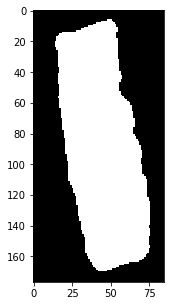

In [42]:
if testing:
    plt.figure(figsize=[5,5])
    plt.imshow(mask,cmap='gray')

## Mandatory Parameters (load mask):
### Either load the recently drawn mask above ('manualcellmask1.tif') or another mask file (e.g. 'cellmask.tif')

In [43]:
if testing:
    from skimage import io
    fpath = 'Data\\Cell2\\Videos_AP'
    mname = 'manualcellmask1.tif' #'manualcellmask1.tif' to use mask dranw above or 'cellmask.tif' to use default mask
    fullpath = fpath + '\\' + mname
    mask = io.imread(fullpath)

## MESS functions:

In [44]:
def build_time_vector(fr,video_shape):
    import numpy as np
    time = np.cumsum(np.ones(video_shape[0]))
    time = (time-1)/fr  
    return(time)

In [45]:
def largestCC(mask):
    from skimage.measure import label
    import numpy as np
    #Gets only largest connected element
    label_msk = label(mask)
    assert( label_msk.max() != 0 ) # assume at least 1 CC
    largestCC = label_msk == np.argmax(np.bincount(label_msk.flat)[1:])+1
    mask = largestCC.astype(bool)
    return(mask)

In [46]:
def create_inner_mask(mask,area_percent=0.5):
    import numpy as np
    import scipy.ndimage as sm
    
            
    structE = np.ones((3,3))

    mask_area = np.sum(mask>0)
    m_erosion = np.copy(mask)
    m_erosion_area = mask_area
    iterations = 0
    while(m_erosion_area>area_percent*mask_area):
        m_erosion = sm.binary_erosion(m_erosion,structure=structE)
        m_erosion_area = np.sum(m_erosion>0)
        iterations+=1
    if iterations<2:
        iterations=2
    if iterations%2==0:
        mask_in = m_erosion
    else:
        iterations-=1
        mask_in = sm.binary_dilation(m_erosion,structure=structE)
    #Gets only largest connected element
    mask_in = largestCC(mask_in)
    
    contourmask = (mask.astype(int)-mask_in.astype(int)).astype(bool)

    return(mask_in,contourmask,iterations)

In [47]:
def standardize_angle(angle):
    if angle<=0:
        angle = angle+180
    elif angle>=180:
        angle = angle-180
    return(angle)

In [48]:
def get_angle(f):
    from skimage.measure import label, regionprops
    import numpy as np
    label_img = label(f)
    regions = regionprops(label_img, coordinates='xy')
    for props in regions:
        if props.area>200:
            orientation = props.orientation
            centroid = props.centroid
    angle = np.rad2deg(orientation)
    angle = standardize_angle(angle)
    return(angle,centroid)

In [49]:
def align_mask(mask,revert=False,theta=0,orig_shape=None):
    if revert==False:
        angle,centroid = get_angle(mask)
        theta = 90-angle
        mask_rot = rotate(mask,theta)
        return(mask_rot,angle)
    else:
        mask_rot,stack_mask_rot = rotate(mask,theta,orig_shape)
        return(mask_rot,stack_mask_rot)

In [50]:
def rotate(f,theta,shape=None):
    import numpy as np
    #if shape is not provided, it means to rotate image, else, it means to reverse a previous rotation
    if shape==None:
        h,w = f.shape
        #make square image
        maxdim = np.amax((h,w))
        f_square = np.zeros((maxdim,maxdim))
        sH,sW = f_square.shape
        f_square[:h,:w] = f
    else:
        sH,sW = f.shape
        f_square = f
        maxdim = sH
    #put square image inside bigger black canvas
    canvas = np.zeros((maxdim,maxdim))
    canvas = np.tile(canvas,(3,3))
    cH,cW = canvas.shape
    canvas[maxdim:maxdim+sH,maxdim:maxdim+sW] = f_square
    
    thetarad = np.deg2rad(theta)
    
    #calculate corrective translation after rotation
    t = np.array([0,0],dtype=float)
    t[1] = (cW-1)/2 - ((cW-1)/2)*np.cos(thetarad) + ((cH-1)/2)*np.sin(thetarad)
    t[0] = (cH-1)/2 - ((cH-1)/2)*np.cos(thetarad) - ((cW-1)/2)*np.sin(thetarad)
    #Rotation & translation
    T = np.array([[np.cos(thetarad),-np.sin(thetarad),t[1]], [np.sin(thetarad),np.cos(thetarad),t[0]], [0,0,1]])  

    y2,x2 = np.indices(canvas.shape)
    n = canvas.size

    yx2 = np.array([ y2.ravel(), 
                    x2.ravel(), 
                    np.ones(n)])
    #Apply affine
    yx2_float = np.linalg.inv(T).dot(yx2)
    #Nearest neighbour
    yy2 = np.rint(yx2_float[0]).astype(int)
    xx2 = np.rint(yx2_float[1]).astype(int)
    #clip indices outside canvas range
    y2 = np.clip(yy2,0,cH-1)
    x2 = np.clip(xx2,0,cW-1)
    #reshape indices into canvas shape
    y2 = y2.reshape(canvas.shape)
    x2 = x2.reshape(canvas.shape)
    #inverse mapping
    g = canvas[y2,x2]
    
    if shape==None:
        d_float = np.sqrt(2)*(sH)
        minr_float = (cH - d_float)/2
        minr = np.rint(minr_float).astype(int)
        minc_float = (cW - d_float)/2
        minc = np.rint(minc_float).astype(int)
        maxr = np.rint(minr_float + d_float).astype(int)
        maxc = np.rint(minc_float + d_float).astype(int)

        if (maxdim % 2) == 0:
            minc+=1
            minr+=1
            maxc-=1
            maxr-=1
    else:
        minr_float = (cH - sH)/2
        minc_float = (cW - sW)/2
        minr = np.rint(minr_float).astype(int)
        minc = np.rint(minc_float).astype(int)
        maxr = np.rint(minr_float + sH).astype(int)
        maxc = np.rint(minc_float + sW).astype(int)
    
    g = g[minr:maxr,minc:maxc]
    
    if shape==None:
        return(g)
    else:
        shape = np.array(shape)
        maxdim = np.amax(shape)
       
        minr_float = (g.shape[0] - maxdim)/2
        minc_float = (g.shape[1] - maxdim)/2
        minr = np.rint(minr_float).astype(int)
        minc = np.rint(minc_float).astype(int)
        maxc = minc + shape[1]
        maxr = minr + shape[0]
        
        #Mode Filter
        from PIL import Image
        im = Image.fromarray(g.astype('uint8'),mode='L')
        from PIL.ImageFilter import ModeFilter
        g = im.filter(ModeFilter)
        g = np.array(g)

        g = g[minr:maxr,minc:maxc]
        nregions = np.amax(g).astype(int)
        g_stack = np.zeros((nregions,g.shape[0],g.shape[1]),dtype=bool)
        for i in range(nregions):
            g_stack[i,g==i+1] = True
        return(g,g_stack)

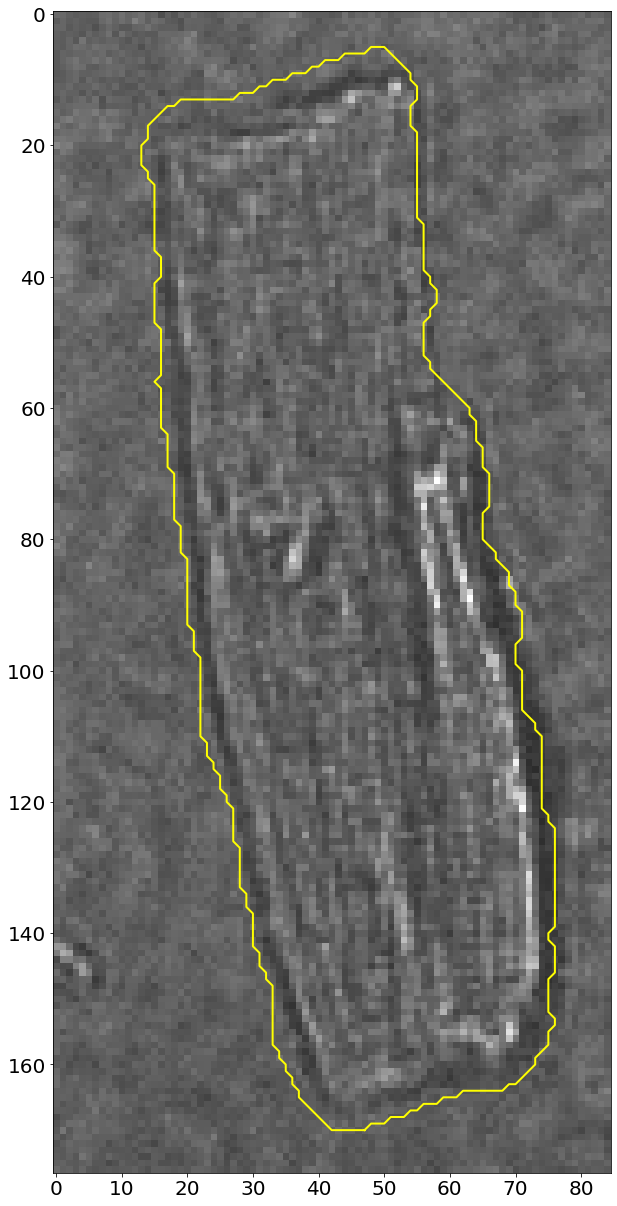

In [51]:
if testing:
    contour = build_contour(mask)
    fig, ax = plt.subplots(figsize=[10,30],nrows=1, ncols=1)
    fpath = 'Data\\Cell2\\videos_AP'
    fullpath = fpath + '\\'+'snap.tif'
    snap = io.imread(fullpath)
    if len(snap.shape)>2:
        from skimage.color import rgb2gray
        snap = rgb2gray(snap)*255
    plt.imshow(snap,cmap='gray',vmin=0,vmax=np.amax(snap))
    ax.plot(contour[:,1],contour[:,0],color='yellow',lw=2)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

In [52]:
def change_format(coord, fig2graph = True, nlines = 255):
    '''Change vector format from image to coordinates or vice-a-versa
       Image has y axis downwards and on first column, cause its the line number
       Image has x axis on second column, cause its the column number'''
    import numpy as np
    new_coord = np.empty(coord.shape)
    if fig2graph==True:
        new_coord[:,1] = nlines-coord[:,0]
        new_coord[:,0] = coord[:,1]
        return(new_coord.astype(float))
    else:
        new_coord[:,1] = coord[:,0]
        new_coord[:,0] = nlines-coord[:,1]
        return(new_coord.astype('uint16'))

In [53]:
def create_contours(mask_aligned, mask_in_aligned, iterations):
    import numpy as np
    import scipy.ndimage as sm
    contours = []
    
    contour_out = build_contour(mask_aligned)
    contour_out = change_format(contour_out, fig2graph=True, nlines = mask_aligned.shape[0])

    contour_in = build_contour(mask_in_aligned)
    contour_in = change_format(contour_in, fig2graph=True, nlines = mask_aligned.shape[0])

    mask_mid = sm.binary_erosion(mask_aligned,structure=np.ones((3,3)),iterations=iterations//2)
    contour_mid = build_contour(mask_mid)
    contour_mid = change_format(contour_mid, fig2graph=True, nlines = mask_aligned.shape[0])

    contourmask_aligned = (mask_aligned.astype(int)-mask_in_aligned).astype(bool)

    contours.append(contour_in)
    contours.append(contour_mid)
    contours.append(contour_out)

    return(contours, contourmask_aligned)

## Divide contour

In [54]:
def arc_length(x, y):
    '''Calculate arc length based on euclidean distance of points
       Each position is the distance from origin to that point'''
    import numpy as np
    npts = len(x)
    L = np.empty((npts-1))
    arc = 0
    for k in range(npts-1):
        arc = arc + np.sqrt((x[k+1] - x[k])**2 + (y[k+1] - y[k])**2)
        L[k] = arc
    return arc, L

In [55]:
def get_idx_percentil(x,y,n_regions=100):
    '''Calculate arc length of contour, divides it in 100 units (percentil) and returns the index of 
       each percentil change in arc length'''
    import numpy as np
    arc, L = arc_length(x,y)
    Ln = L/arc
    n_regions = np.rint(n_regions).astype(int)
    percentil_change = np.floor(Ln*n_regions)
    unique, pos = np.unique(percentil_change[:-1], return_index=True)
    return(pos, arc, Ln)

In [56]:
def get_centroid(msk):
    msk = largestCC(msk)
    '''Get central point of shape'''
    from skimage.measure import label, regionprops
    label_img = label(msk)
    regions = regionprops(label_img, coordinates='xy')
    for props in regions:
        y0, x0 = props.centroid
    return(x0, y0)

In [57]:
def rearange(contours, y0):
    '''Reorganize vector in order for the first positions to be those at the same y as the centroid (or any given y)'''
    import numpy as np
    index_pos_init = np.where(contours[:-1,1]==round(y0))[0]  #indices onde y == y0
    if contours[index_pos_init[0],0] > contours[index_pos_init[1],0]:  #posição inicial recebe indice onde x for maior
        pos_init = index_pos_init[0]
    else:
        pos_init = index_pos_init[1]
    last_idx = contours.shape[0]-1
    new_contours = np.empty_like(contours)
    new_contours[:(last_idx-pos_init),:] = contours[pos_init:last_idx,:]
    new_contours[(last_idx-pos_init):-1,:] = contours[:pos_init,:]
    new_contours[last_idx,:] = contours[pos_init,:]
    return(new_contours)

In [58]:
def perpendicular_eq(x,y,first=False,points=10):
    '''Calculate the perpendicular equation (vector) of the line provided by vectors x and y
        first: if True, it means the case when the routine is run for the first time and the perpendicular line is given crossing
        the origin point, otherwise it is given crossing the last point
        points: number of points that the perpencidular line will have'''
    import numpy as np
    if first==True:
        u0 = x[0]
        v0 = y[0]
    else:
        u0 = x[1]
        v0 = y[1]
    if x[1]==x[0]:
        v = np.ones(2*points)*v0
        u = np.arange(u0-points, u0+points)
    elif y[1]==y[0]:
        u = np.ones(2*points)*u0
        v = np.arange(v0-points, v0+points)
    else:
        alpha = (y[1] - y[0]) / (x[1] - x[0])
        beta = -1/alpha
        if abs(beta)<=1:
            u = np.arange(u0-points, u0+points)
            v = v0 + beta*(u - u0)
        else:
            v = np.arange(v0-points,v0+points)
            u = ((v - v0)/beta) + u0
    return(u,v)

In [59]:
def nearest_point(x,y,u,v,idx,N):
    '''x and y: contour (out or in) points (part of contour)
       u and v: perpendicular line points (return from perpendicular_eq)
       idx: actual index of contour
       N: length of contour (out or in) vector (whole vector)
    '''
    import numpy as np
    n = len(x)
    p = n/2
    D = np.empty(len(x))
    for i in range(n):
        D[i] = np.amin(np.sqrt((x[i] - u)**2 + (y[i] - v)**2))
    #Minimum distance (Dmin) and roll quantity (rolls) that led to minimum distance
    Dmin = np.amin(D)
    imin = np.argmin(D)
    
    if imin<0:
        imin = n + imin
    idx_min = idx + (imin - p)
    if idx_min >= N:
        idx_min = idx_min - N
    elif idx_min < 0:
        idx_min = idx_min + N
    return(x[imin],y[imin],Dmin,idx_min.astype(int))

### Creates vectors containing points of arc length division

In [60]:
def create_separation_landmarks(contours,mask_aligned,n_ROIs_out):
    import numpy as np
    (xc, yc) = get_centroid(mask_aligned)
    yc = mask_aligned.shape[0]-yc

    centroid = (xc,yc)
    contours[0] = rearange(contours[0],yc)
    contours[1] = rearange(contours[1],yc)
    contours[2] = rearange(contours[2],yc)

    pos_in, arc_in, normalized_length_in = get_idx_percentil(contours[0][:,0], contours[0][:,1],n_regions=n_ROIs_out)
    pos_mid, arc_mid, normalized_length_mid = get_idx_percentil(contours[1][:,0], contours[1][:,1],n_regions=n_ROIs_out)
    pos_out, arc_out, normalized_length_out = get_idx_percentil(contours[2][:,0], contours[2][:,1],n_regions=n_ROIs_out)

    '''First column:  counter
       Second column: percentil indices of middle contour rolled 1 unit
       Third column:  percentil indices of middle contour
       Forth column:  percentil indices of inner contour
       Fifth column:  percentil indices of outter (original) contour'''
    separation_landmark_vector = np.empty((len(pos_mid),5),'uint16')
    separation_landmark_vector[:,0] = np.arange(len(pos_mid))
    separation_landmark_vector[:,2] = pos_mid
    separation_landmark_vector[:,1] = np.roll(pos_mid,1)
    separation_landmark_vector[:,3] = pos_in
    separation_landmark_vector[:,4] = pos_out

    return(separation_landmark_vector)
    

### Create ROIs

In [61]:
def connect_points(x0,y0,x1,y1):
    '''Create a line (vector) that connects two points
       The line always contains a y for each x and vice-a-versa'''
    import numpy as np
    inv = False
    if x1==x0:
        if y0>y1:
            inv=True
            temp = (x0,y0)
            x0,y0 = x1,y1
            x1,y1 = temp
        u = np.ones(y1-y0)*x0
        v = np.arange(y0, y1)
    elif y1==y0:
        if x0>x1:
            inv=True
            temp = (x0,y0)
            x0,y0 = x1,y1
            x1,y1 = temp
        u = np.arange(x0, x1)
        v = np.ones(x1-x0)*y0
    else:
        alpha = (y1 - y0) / (x1 - x0)
        if (abs(x1-x0))>=(abs(y1-y0)):
            if x1<x0:
                inv = True
                u = np.arange(x1, x0+1)
            else:
                u = np.arange(x0, x1+1)
            v = np.rint(y0 + alpha*(u - x0))
        else:
            if y1<y0:
                inv = True
                v = np.arange(y1, y0+1)
            else:
                v = np.arange(y0, y1+1)
            u = np.rint(((v-y0)/alpha) + x0)
    line = np.empty((np.size(u),2))
    line[:,0] = u
    line[:,1] = v
    if inv==True:
        line = line[::-1]
    return(line)

In [62]:
def close_region(c_in,c_out):
    '''Given two curves, connects the extremities through lines and therefore closes the region
       Obs: May include repeated values in the output'''
    import numpy as np
    line1 = connect_points(c_in[0,0],c_in[0,1],c_out[0,0],c_out[0,1])
    line2 = connect_points(c_out[-1,0],c_out[-1,1],c_in[-1,0],c_in[-1,1])
    contour = np.concatenate((c_in[::-1],line1,c_out,line2))
    return(contour)

In [63]:
def yx_ord(contour,xy=False):
    import numpy as np
    if xy==True:
        contour[:,[0, 1]] = contour[:,[1, 0]]
    #order based on y
    idx_y_ordered = np.argsort(contour[:,0]).astype(int)
    contour_yord = contour[idx_y_ordered,:]
    #in each y ordered slice, order based on x
    coord_size = contour_yord.shape[0]
    contour_yxord = np.zeros_like(contour_yord)
    slice_row=0
    while slice_row<coord_size:
        y0 = contour_yord[slice_row,0]
        slice_contour_yord = contour_yord[contour_yord[:,0]==y0,:]
        slice_size = slice_contour_yord.shape[0]
        slice_idx_x_ordered = np.argsort(slice_contour_yord[:,1]).astype(int)
        slice_contour_yxord = slice_contour_yord[slice_idx_x_ordered,:]
        contour_yxord[slice_row:slice_row+slice_size,:] = slice_contour_yxord
        slice_row+=slice_size
    return(contour_yxord).astype(int)

In [64]:
def contains_point(x,y,contour):
    from matplotlib.path import Path
    path = Path(contour, closed=True)
    return(path.contains_point([x, y],radius=-1e-9))

In [65]:
def flood_fill(bb,y,x,old_color,new_color):
    if bb[y,x] == new_color: # the base case
        return
    bb[y,x] = new_color
    q = []
    q.append([y,x])
    while(len(q)>0):
        yn,xn = q.pop()
        if yn < bb.shape[0]-1:
            if bb[yn+1,xn]==old_color:
                bb[yn+1,xn] = new_color  # down
                q.append([yn+1,xn])
        if xn < bb.shape[1]-1:
            if bb[yn,xn+1]==old_color:
                bb[yn,xn+1] = new_color  # right
                q.append([yn,xn+1])    
        if xn > 0:
            if bb[yn,xn-1]==old_color:
                bb[yn,xn-1] = new_color  # left
                q.append([yn,xn-1])
        if yn > 0:
            if bb[yn-1,xn]==old_color:
                bb[yn-1,xn] = new_color  # up
                q.append([yn-1,xn]) 

In [66]:
def fill_region(contour,shape):
    '''Converts coordinates to image and fills the region'''
    import numpy as np
    contour = change_format(contour, fig2graph=False, nlines=shape[0])
    contour_yx = yx_ord(contour)
    msk = np.zeros(shape,bool)
    msk[contour_yx[:,0],contour_yx[:,1]] = True
    bb = msk[contour_yx[0,0]:contour_yx[-1,0]+1,np.amin(contour_yx[:,1]):np.amax(contour_yx[:,1])+1]
    starting_node = np.array([contour_yx[0,0],contour_yx[0,1]])
    bbmin = np.array([contour_yx[0,0],np.amin(contour_yx[:,1])])
    starting_node_bb = starting_node - bbmin
    good_start = False
    i = 1
    directions=0
    while good_start==False:
        
        if directions==0:
            directions+=1
            if starting_node_bb[0] < bb.shape[0]-1:
                good_start = contains_point(starting_node_bb[0]+1,starting_node_bb[1],contour-bbmin)  #check down
                if good_start:
                    starting_node_bb[0]+=1
        elif directions==1:
            directions+=1
            if starting_node_bb[1] < bb.shape[1]-1:
                good_start = contains_point(starting_node_bb[0],starting_node_bb[1]+1,contour-bbmin)  #check right
                if good_start:
                    starting_node_bb[1]+=1
        elif directions==2:
            directions+=1
            if starting_node_bb[1] > 0:
                good_start = contains_point(starting_node_bb[0],starting_node_bb[1]-1,contour-bbmin)  #check left
                if good_start:
                    starting_node_bb[1]-=1
        elif directions==3:
            directions+=1
            if starting_node_bb[0] > 0:
                good_start = contains_point(starting_node_bb[0]-1,starting_node_bb[1],contour-bbmin)  #check up
                if good_start:
                    starting_node_bb[0]-=1
        else:
            directions = 0
            i+=1
            starting_node = np.array([contour_yx[i,0],contour_yx[i,1]])
            starting_node_bb = starting_node - bbmin

    flood_fill(bb,starting_node_bb[0],starting_node_bb[1],False,True)
    
    msk[contour_yx[0,0]:contour_yx[-1,0]+1,np.amin(contour_yx[:,1]):np.amax(contour_yx[:,1])+1] = bb
    return(msk)

In [67]:
def reorder_anodefirst(slices,label_ROIs):   
    import numpy as np
    nregions=slices.shape[0]

    indices_true = np.argwhere(slices)
    line_with_min_ycoord = np.argmin(indices_true[:,1])
    ROIidx_with_min_ycoord = indices_true[line_with_min_ycoord,0]

    new_label_ROIs = np.copy(label_ROIs)
    new_label_ROIs[label_ROIs>ROIidx_with_min_ycoord] = new_label_ROIs[label_ROIs>ROIidx_with_min_ycoord] - ROIidx_with_min_ycoord
    new_label_ROIs[label_ROIs<=ROIidx_with_min_ycoord] = new_label_ROIs[label_ROIs<=ROIidx_with_min_ycoord] + (nregions - ROIidx_with_min_ycoord)
    new_label_ROIs[label_ROIs==0] = 0
    
    order_idx = np.arange(nregions,dtype=int)
    order_idx = np.roll(order_idx,-ROIidx_with_min_ycoord)
    reordered_slices = slices[order_idx,:,:]
    
    return(reordered_slices,new_label_ROIs)

### Create outer ROIs

In [68]:
def create_out_ROIs(contours,separation_landmarks,mask_aligned,contourmask,angle,sensib=1,testing=False):
    import numpy as np
    #Creates vectors and calculates outputs for first percentil
    pout = np.rint(contours[2].shape[0]*0.25*sensib).astype(int) 
    p=pout
    pin = np.rint(contours[0].shape[0]*0.15*sensib).astype(int)  
    cum_seg_mask = np.zeros((mask_aligned.shape),dtype=bool)
    label_ROIs = np.zeros((mask_aligned.shape),dtype=int)
    #middle contour first perpendicular
    u,v = perpendicular_eq(contours[1][:2,0],contours[1][:2,1],first=True,points=p)
    N = len(separation_landmarks)

    x_near_in = np.empty((N,),dtype='uint16')
    y_near_in = np.empty((N,),dtype='uint16')
    D_in = np.empty((N,),dtype='float64')
    idx_in = np.empty((N,),dtype=int)

    x_near_out = np.empty((N,),dtype='uint16')
    y_near_out = np.empty((N,),dtype='uint16')
    D_out = np.empty((N,),dtype='float64')
    idx_out = np.empty((N,),dtype=int)

    segment_aligned = np.zeros((N,mask_aligned.shape[0],mask_aligned.shape[1]),bool)

    u = contours[1][0,0]
    v = contours[1][0,1]

    x_near_in[0],y_near_in[0],D_in[0],idx_in[0] = nearest_point(
        np.concatenate((contours[0][-pin:,0],contours[0][0:pin,0])),                      
        np.concatenate((contours[0][-pin:,1],contours[0][0:pin,1])),        
        u,v,separation_landmarks[0,3],np.shape(contours[0])[0])         
    idx_in[0] = 0

    x_near_out[0],y_near_out[0],D_out[0],idx_out[0] = nearest_point(
        np.concatenate((contours[2][-pout:,0],contours[2][0:pout,0])),
        np.concatenate((contours[2][-pout:,1],contours[2][0:pout,1])),
        u,v,separation_landmarks[0,4],np.shape(contours[2])[0])             
    idx_out[0] = 0

    if testing:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=[10,25],nrows=1, ncols=1)
        ax.plot(contours[0][:,0],contours[0][:,1],color='lightgray',lw=6)  # x (col), y (lin) IN
        ax.plot(contours[1][:,0],contours[1][:,1],color='gray',lw=6)  # x (col), y (lin) MID
        ax.plot(contours[2][:,0],contours[2][:,1],color='k',lw=6)  # x (col), y (lin) OUT
        ax.plot(contours[1][0,0],contours[1][0,1],'o',ms=20,mew=5,color='lime') #first point
        ax.plot((x_near_in[0],x_near_out[0]),(y_near_in[0],y_near_out[0]),'--',lw=9,color='red')
        ax.plot(x_near_out[0],y_near_out[0],'x',ms=20,mew=5,color='blue') #first crossing OUT
        ax.plot(x_near_in[0],y_near_in[0],'x',ms=20,mew=5,color='blue')   #first crossing IN

    #Calculates perpendicular lines for each percentil from central contour and finds nearest point in surrounding contours
    #to delimitate regions
    #Creates masks for each region

    for i,j,k,kin,kout in separation_landmarks[1:,:]:

        x = (contours[1][j,0],contours[1][k,0])
        y = (contours[1][j,1],contours[1][k,1])
        u,v = perpendicular_eq(x,y,points=p)

        u = contours[1][k,0]
        v = contours[1][k,1]

        #Conditions if segment is close to the beginning or ending of the vector contour_in
        if kin<pin:
            x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = nearest_point(
                np.concatenate((contours[0][kin-pin:,0],contours[0][:kin+pin,0])),
                np.concatenate((contours[0][kin-pin:,1],contours[0][:kin+pin,1])),
                u,v,kin,np.shape(contours[0])[0])
        elif kin>(len(contours[0])-pin):
            x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = nearest_point(
                np.concatenate((contours[0][kin-pin:,0],contours[0][:((pin-(len(contours[0])-kin))),0])),
                np.concatenate((contours[0][kin-pin:,1],contours[0][:((pin-(len(contours[0])-kin))),1])),
                u,v,kin,np.shape(contours[0])[0])
        else:
            x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = nearest_point(
                contours[0][kin-pin:kin+pin,0],
                contours[0][kin-pin:kin+pin,1],
                u,v,kin,np.shape(contours[0])[0])

        #Condition where a perpendicular lines crosses in_contour before the earlier point: keeps the earlier point
        if (idx_in[i] < idx_in[i-1]):
            if (i<N-1) | (idx_in[i] > idx_in[i-1]//10):
                print('in',idx_in[i],idx_in[i-1])
                x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = x_near_in[i-1],y_near_in[i-1],D_in[i-1],idx_in[i-1]

        #Conditions if segment is close to the beginning or ending of the vector contour_out
        if kout<pout:
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = nearest_point(
                np.concatenate((contours[2][kout-pout:,0],contours[2][:kout+pout,0])),
                np.concatenate((contours[2][kout-pout:,1],contours[2][:kout+pout,1])),
                u,v,kout,np.shape(contours[2])[0])
        elif kout>(len(contours[2])-pout):
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = nearest_point(
                np.concatenate((contours[2][kout-pout:,0],contours[2][:((pout-(len(contours[2])-kout))),0])),
                np.concatenate((contours[2][kout-pout:,1],contours[2][:((pout-(len(contours[2])-kout))),1])),
                u,v,kout,np.shape(contours[2])[0])
        else:
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = nearest_point(
                contours[2][kout-pout:kout+pout,0],
                contours[2][kout-pout:kout+pout,1],
                u,v,kout,np.shape(contours[2])[0])

        #Condition where a perpendicular lines crosses out_contour before the earlier point: keeps the earlier point
        if idx_out[i] < idx_out[i-1]:
            print('out',idx_out[i],idx_out[i-1])
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = x_near_out[i-1],y_near_out[i-1],D_out[i-1],idx_out[i-1]
        
        if testing:
            ax.plot(contours[1][k,0],contours[1][k,1],'o',ms=20,mew=5,color='k')
            ax.plot((x_near_in[i],x_near_out[i]),(y_near_in[i],y_near_out[i]),'--',lw=9,color='red')
            ax.plot(u,v,'--',lw=2,color='gray')
            ax.plot(x_near_out[i],y_near_out[i],'x',ms=20,mew=5,color='blue')
            ax.plot(x_near_in[i],y_near_in[i],'x',ms=20,mew=5,color='blue')
            ax.axis('off')

        if (idx_in[i-1]==idx_in[i]):
            closed_segment = close_region(contours[0][idx_in[i]:idx_in[i]+1,:].astype(int),contours[2][idx_out[i-1]:idx_out[i],:].astype(int))
        elif (idx_out[i-1]==idx_out[i]):
            closed_segment = close_region(contours[0][idx_in[i-1]:idx_in[i],:].astype(int),contours[2][idx_out[i]:idx_out[i]+1,:].astype(int))
        else:
            closed_segment = close_region(contours[0][idx_in[i-1]:idx_in[i]+1,:].astype(int),contours[2][idx_out[i-1]:idx_out[i]+1,:].astype(int))
        seg_mask = fill_region(closed_segment, mask_aligned.shape)
        segment_aligned[i-1,:,:] = seg_mask
        cum_seg_mask = cum_seg_mask + seg_mask
        label_ROIs = label_ROIs + cum_seg_mask
        #Deals with overlapping ROIs
        if i>1:
            common_mask = np.logical_and(segment_aligned[i-2,:,:],seg_mask)
            segment_aligned[i-2,common_mask] = False
            label_ROIs[common_mask] = label_ROIs[common_mask] - 1

    #Calculates mask for last percentil
    closed_segment = close_region(contours[0][idx_in[N-1]:-1,:].astype(int),contours[2][idx_out[N-1]:-1,:].astype(int))
    seg_mask = fill_region(closed_segment, mask_aligned.shape)
    segment_aligned[N-1,:,:] = seg_mask
    cum_seg_mask = cum_seg_mask + seg_mask
    label_ROIs = label_ROIs + cum_seg_mask
    label_ROIs[cum_seg_mask] = np.amax(label_ROIs)+1 - label_ROIs[cum_seg_mask] 
    #Deals with overlapping ROIs
    common_mask = np.logical_and(segment_aligned[N-2,:,:],seg_mask)
    segment_aligned[N-2,common_mask] = False

    segment_mask = segment_aligned
    
    segment_mask,label_ROIs = reorder_anodefirst(segment_mask,label_ROIs)

    return(segment_mask,label_ROIs)

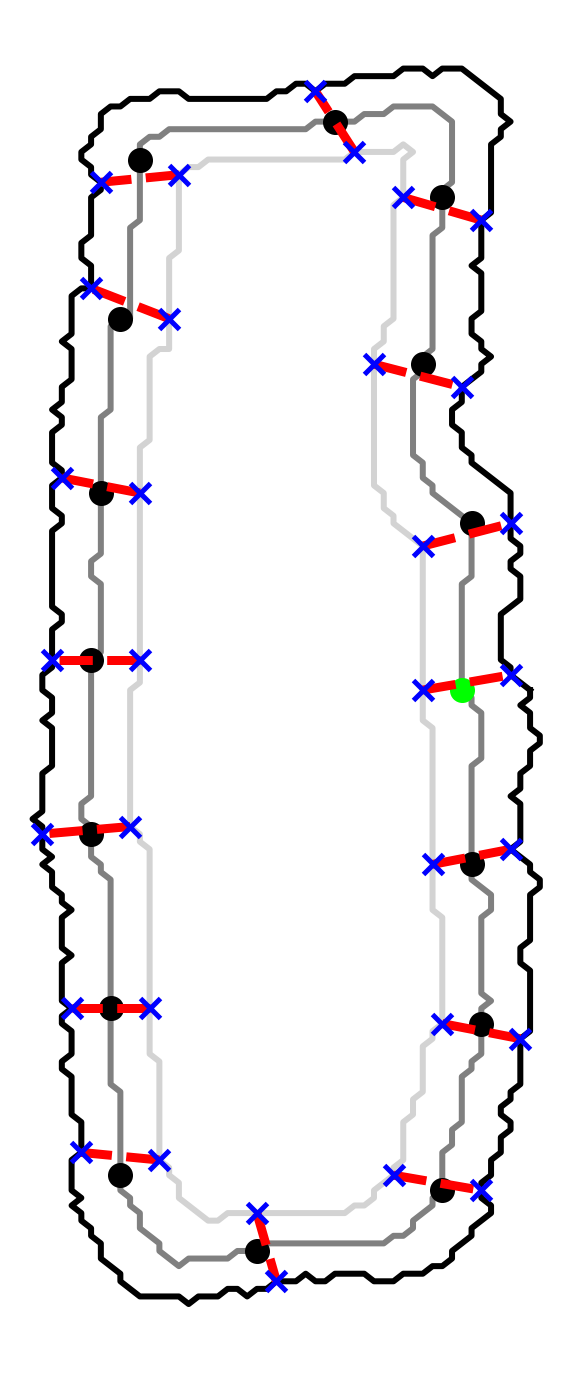

In [69]:
if testing:
    n_ROIs_out=16
    n_ROIs_in=16
    sensib = 1
    n_ROIs_total = n_ROIs_out + n_ROIs_in
    area_percent = np.around((n_ROIs_in/n_ROIs_total),decimals=2)
    #Creates inner (smaller) mask
    mask_in, mask_contour, it = create_inner_mask(mask,area_percent)
    
    #Alignes masks to vertical position
    mask_aligned,angle = align_mask(mask)
    #Create inner mask aligned
    import scipy.ndimage as sm
    mask_in_aligned = sm.binary_erosion(mask_aligned,structure=np.ones((3,3)),iterations=it)
    mask_in_aligned = largestCC(mask_in_aligned)
    
    #Creates contour_out, contour_mid and contour_in from mask and inner mask
    contours, contourmask_aligned = create_contours(mask_aligned, mask_in_aligned, it)

    #Divide contours in equal lengths and create a vector storing separation landmarks for later ROI design
    separation_landmarks = create_separation_landmarks(contours,mask_aligned,n_ROIs_out)

    #Generates outter ROIs
    segments, label_ROIs_out = create_out_ROIs(contours,separation_landmarks,mask_aligned,mask_contour,angle,sensib,testing)

### Create inner ROIs

In [70]:
def reorder_slices(slices,label_ROIs):
    import numpy as np
    nregions=slices.shape[0]

    order_idx = np.arange(nregions,dtype=int)

    order_idx[(nregions//2)+1:] = order_idx[-2:(nregions//2)-1:-1]
    order_idx[nregions//2] = nregions-1

    order_idx = np.roll(order_idx,nregions//4)
    
    reordered_slices = slices[order_idx,:,:]
    
    indices = np.arange(0,nregions)+1
    order_idx+=1
    new_label_ROIs = np.copy(label_ROIs)
    for j in range(nregions):
        new_label_ROIs[label_ROIs==order_idx[j]] = indices[j]
    
    return(reordered_slices,new_label_ROIs)

In [71]:
def get_slices(mask,mask_rot,angle,nregions=16,testing=False,contours=None):
    import numpy as np
    if testing:
        plt.figure(figsize=[10,25])
        plt.plot(contours[0][:,0],contours[0][:,1],color='lightgray',lw=6)
        plt.plot(contours[2][:,0],contours[2][:,1],color='k',lw=6)
        plt.axis('off')

    cum_seg_mask = np.zeros((mask_rot.shape),dtype=bool)
    label_ROIs = np.zeros((mask_rot.shape),dtype=int)
    
    segment = np.zeros((nregions,mask.shape[0],mask.shape[1]),dtype='bool')
    mask_rot_area = np.sum(mask_rot>0)
    region_rot_area = mask_rot_area/nregions
    segment_rot = np.zeros((nregions,mask_rot.shape[0],mask_rot.shape[1]),dtype='bool')
    x0,y0 = get_centroid(mask_rot)
    x0 = x0.astype(int)

    inner_mask_rot = np.copy(mask_rot)    

    mask_rot_integral = np.cumsum(mask_rot).reshape((mask_rot.shape))*mask_rot
    
    #Gets first region
    region_startline = np.nonzero(mask_rot_integral>0)[0][0]
    region_endline = np.nonzero(mask_rot_integral>((1)*region_rot_area))[0][0]
    segment_rot[0,region_startline:region_endline,:] = 1
    segment_rot[0,:,:] = segment_rot[0,:,:]*mask_rot
    inner_mask_rot[region_startline:region_endline,:] = 0
    cum_seg_mask = cum_seg_mask + segment_rot[0,:,:]
    label_ROIs = label_ROIs + cum_seg_mask

    if testing:
        region_endline2 = mask_rot.shape[0]-region_endline
        index_pos = np.where(contours[0][:-1,1]==round(region_endline2))[0]  #indices onde y == y0
        xvalues = np.sort(contours[0][index_pos,0].astype(int))
        plt.plot(np.arange(xvalues[0],xvalues[1]+1,1),np.ones((xvalues[1]+1-xvalues[0]))*region_endline2,'--',color='r',lw=6)
    
    #Gets last region
    region_startline = np.nonzero(mask_rot_integral>((nregions-1)*region_rot_area))[0][0]
    region_endline = np.nonzero(mask_rot)[0][-1]
    segment_rot[-1,region_startline:region_endline+1,:] = 1
    segment_rot[-1,:,:] = segment_rot[-1,:,:]*mask_rot
    inner_mask_rot[region_startline+1:region_endline+1,:] = 0
    
    if testing:
        region_startline2 = mask_rot.shape[0]-region_startline
        index_pos = np.where(contours[0][:-1,1]==round(region_startline2))[0]  #indices onde y == y0
        xvalues = np.sort(contours[0][index_pos,0].astype(int))
        plt.plot(np.arange(xvalues[0],xvalues[1]+1,1),np.ones((xvalues[1]+1-xvalues[0]))*region_startline2,'--',color='r',lw=6)
        plt.plot(np.ones((region_endline2+1-region_startline2))*x0,np.arange(region_startline2,region_endline2+1),'--',color='r',lw=6)
    
    for j in range(2):
        half_mask_rot = np.zeros_like(inner_mask_rot)
        if j==0:
            half_mask_rot[:,:x0] = inner_mask_rot[:,:x0]
        else:
            half_mask_rot[:,x0:] = inner_mask_rot[:,x0:]
        half_mask_rot_area = np.sum(half_mask_rot>0)
        new_region_rot_area = half_mask_rot_area/((nregions-2)//2)
        half_mask_rot_integral = np.cumsum(half_mask_rot).reshape((half_mask_rot.shape))*half_mask_rot

        for i in range((nregions-2)//2):
            k=i+j*((nregions-2)//2)


            region_startline = np.nonzero(half_mask_rot_integral>(i*new_region_rot_area))[0][0]
            if i==(((nregions-2)//2)-1):
                region_endline = np.nonzero(half_mask_rot)[0][-1]
            else:
                region_endline = np.nonzero(half_mask_rot_integral>((i+1)*new_region_rot_area))[0][0]
                if testing:
                    region_endline2 = mask_rot.shape[0]-region_endline
                    index_pos = np.where(contours[0][:-1,1]==round(region_endline2))[0]  #indices onde y == y0
                    if j==0:
                        xvalues = np.amin(contours[0][index_pos,0].astype(int))
                        plt.plot(np.arange(xvalues,x0+1,1),np.ones((x0+1-xvalues))*region_endline2,'--',color='r',lw=6)
                    else:
                        xvalues = np.amax(contours[0][index_pos,0].astype(int))
                        plt.plot(np.arange(x0,xvalues+1,1),np.ones((xvalues+1-x0))*region_endline2,'--',color='r',lw=6)
                        
            segment_rot[k+1,region_startline:region_endline,:] = 1
            segment_rot[k+1,:,:] = segment_rot[k+1,:,:]*half_mask_rot
            cum_seg_mask = cum_seg_mask + segment_rot[k+1,:,:]
            label_ROIs = label_ROIs + cum_seg_mask
    
    cum_seg_mask = cum_seg_mask + segment_rot[-1,:,:]
    label_ROIs = label_ROIs + cum_seg_mask
    label_ROIs[cum_seg_mask] = np.amax(label_ROIs)+1 - label_ROIs[cum_seg_mask]

    segment = segment_rot
    segment,label_ROIs = reorder_slices(segment,label_ROIs)
    segment,label_ROIs = reorder_anodefirst(segment,label_ROIs)

    return(segment,label_ROIs)

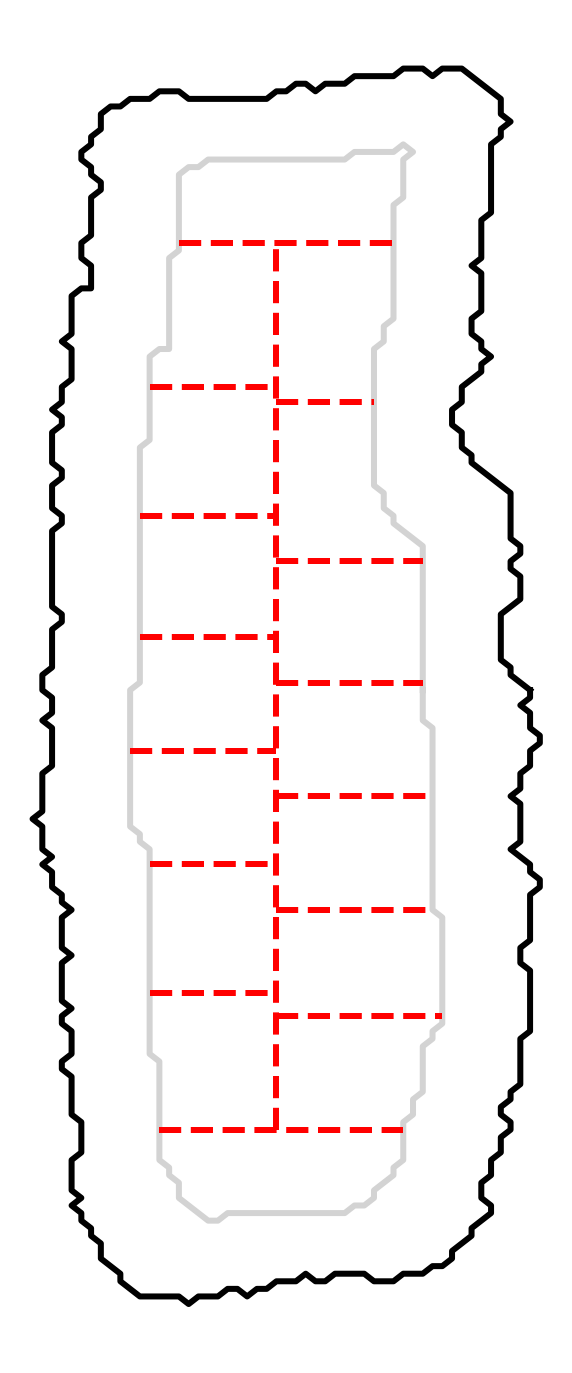

In [72]:
if testing:
    angle_in = angle
    slices,label_ROIs_in = get_slices(mask_in,mask_in_aligned,angle_in,n_ROIs_in,testing,contours)

### Get ROIs means

In [73]:
def get_ROIs_means(video,ROIs):
    import numpy as np
    region_avg = np.empty((video.shape[0],ROIs.shape[0]),'float64') #vector with size = number of regions
    for k in range(video.shape[0]): #iteration over each frame
        for j in range(ROIs.shape[0]): #iteration over each region
            region_avg[k,j] = np.mean(video[k][ROIs[j]]) #video frame k, indexado pela mascara de segmento j
            #linha é numero do frame, coluna é o numero da microregião
    return(region_avg)

# Main Function:

In [74]:
def segment(mask, video=None, fr=None, n_ROIs_out=16, n_ROIs_in=16, sensib=1):
    import numpy as np
    ROIs_means,time = None,None
    n_ROIs_total = n_ROIs_out + n_ROIs_in
#     #Get videos .tif from path

    if video is not None:
        #Get video shape
        video_shape = video.shape
        #if single image, don't get means
        if len(video_shape)>2:
            f0 = video[0]
            #Build time vector
            time = build_time_vector(fr, video_shape)
        else:
            f0 = video

    #Create an inner mask and a contour mask
    area_percent = np.around((n_ROIs_in/n_ROIs_total),decimals=2)
    
        
    mask_in, mask_contour, it = create_inner_mask(mask,area_percent)
    
    #Alignes masks to vertical position
    mask_aligned,angle = align_mask(mask)

    #Create inner mask aligned
    import scipy.ndimage as sm
    mask_in_aligned = sm.binary_erosion(mask_aligned,structure=np.ones((3,3)),iterations=it)
    mask_in_aligned = largestCC(mask_in_aligned)
    
    #Create contour_out, contour_mid and contour_in from mask and inner mask
    contours, contourmask_aligned = create_contours(mask_aligned, mask_in_aligned, it)

    #Divide contours in equal lengths and create a vector storing separation landmarks for later ROI design
    separation_landmarks = create_separation_landmarks(contours,mask_aligned,n_ROIs_out)

    #Generates outter ROIs
    segments, label_ROIs_out = create_out_ROIs(contours,separation_landmarks,mask_aligned,mask_contour,angle,sensib)

    #Generates inner ROIs
    angle_in = angle
#    import matplotlib.pyplot as plt
#    plt.subplot(121)
#    plt.imshow(mask_in,cmap='gray')
#    plt.subplot(122)
#    plt.imshow(mask_in_aligned,cmap='gray')
    slices,label_ROIs_in = get_slices(mask_in,mask_in_aligned,angle_in,nregions = n_ROIs_in)
    
    label_ROIs_in[label_ROIs_in>0] = label_ROIs_in[label_ROIs_in>0] + n_ROIs_out
    label_ROIs = label_ROIs_out + label_ROIs_in
   
    #Rotate mask (and ROIs) back to original angle
    label_ROIs,stack_ROIs = align_mask(label_ROIs,revert=True,theta=angle-90,orig_shape=mask.shape)
    
    #Keep just pixels in the original mask (i.e. exclude extra pixels usually added after rotations)
    label_ROIs[mask==False] = 0
    for i in range(stack_ROIs.shape[0]):
        stack_ROIs[i][mask==False] = False
    
    if video is not None:
        if len(video_shape)>2:
            #Get smaller ROIs means
            ROIs_means = get_ROIs_means(video,stack_ROIs)
            return(stack_ROIs,label_ROIs,ROIs_means,time)
    else: #if single image, don't get means
        return(stack_ROIs,label_ROIs)

# Test

In [75]:
if testing:
    ROIs_masks, label_ROIs, ROIs_means, time  = segment(mask, video, fr)
#     ROIs_masks, label_ROIs  = segment(mask, None, None)

# Time of main function execution:

In [76]:
if testing:
    %timeit ROIs_masks, label_ROIs, ROIs_means, time  = segment(mask, video, fr)

427 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plot results

Create colormap

In [77]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)

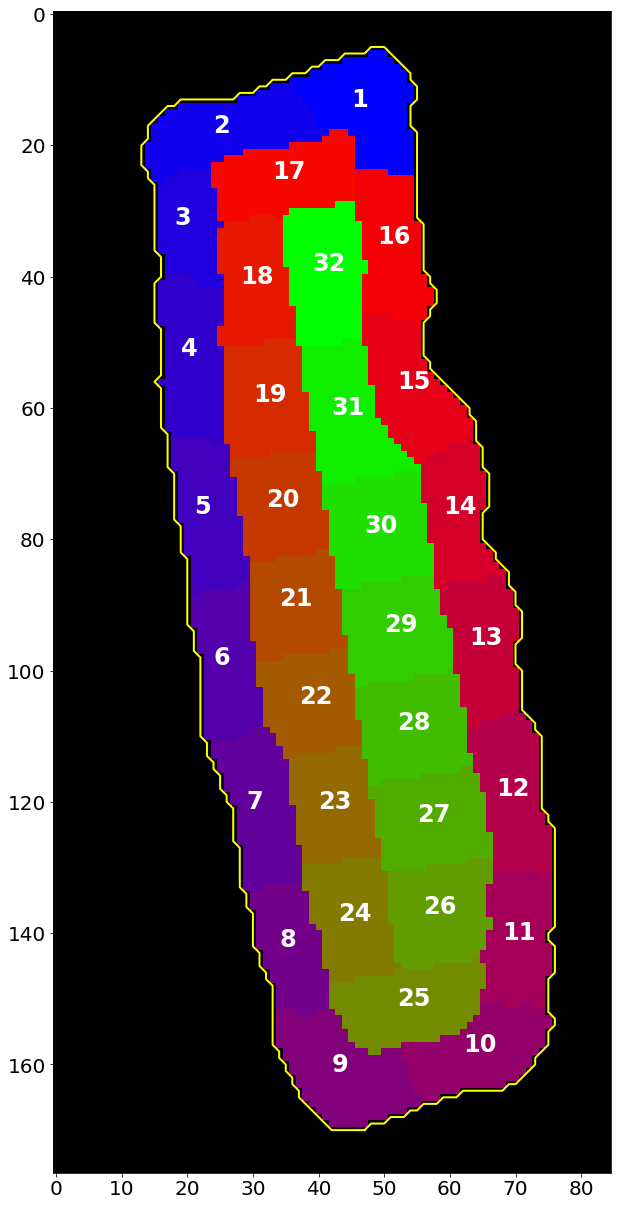

In [78]:
if testing:
    fig, ax = plt.subplots(figsize=[10,30],nrows=1, ncols=1)
    ax.imshow(label_ROIs, cmap=newcmp)
    cent_coord = np.zeros((nregions,2))
    for j in range(nregions):
        cent_coord[j,:] = np.rint(get_centroid(ROIs_masks[j,:,:]))
        ax.annotate(j+1,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=24,weight='bold') 
    ax.plot(contour[:,1],contour[:,0],color='yellow',lw=2)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

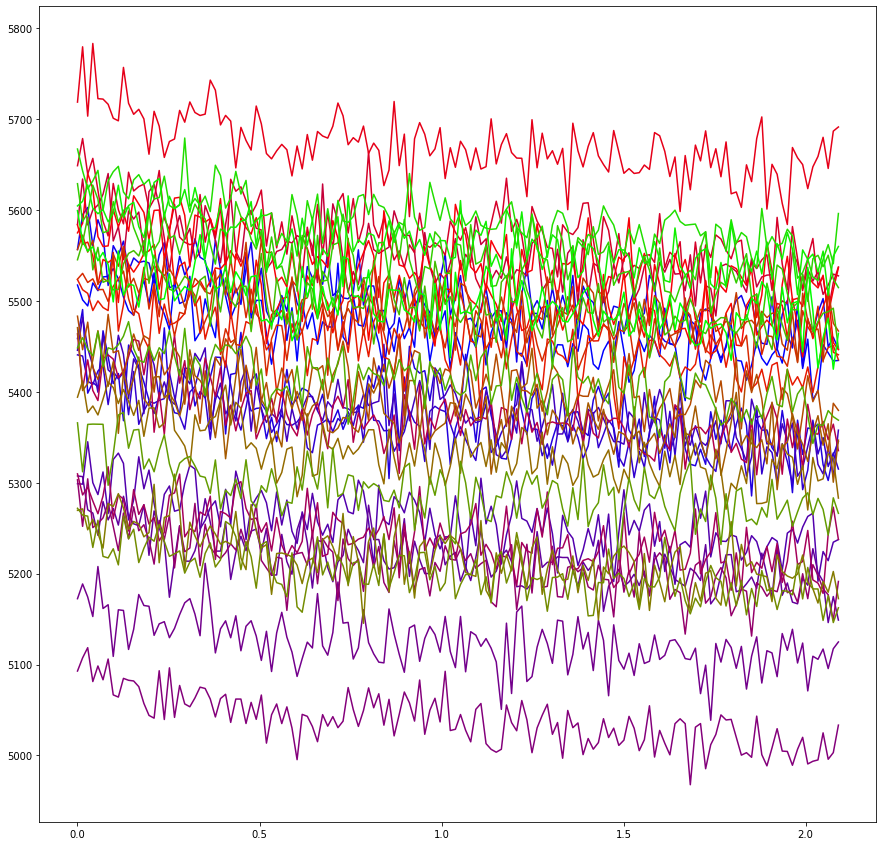

In [79]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,15])
    for i in range(nregions):
        ax1.plot(time,ROIs_means[:,i],color=newcolors[i+1])